# Lets train deep nn


#STUDY MORE:::
  * **1. BatchNormalization**
  * 2.*study the Use of* **pytorch**
  * **3. Getting Used to Diagnostic Tools**:
      + **Statistics**, **Histograms** of the Forward pass activation,
      + *Backward pass Gradient*
      + the weights that are going to update part of the Stochastic grad, Looking at there **Mean**, **Starndard Deviation**, *The ratio of grad's to Data*, ** The Updates to Data**

In [ ]:
#Lets train deeper nn
import torch
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [ ]:

words = open('/content/sample_data/names.txt', 'r').read().splitlines()
words[:4]

['emma', 'olivia', 'ava', 'isabella']

In [ ]:

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocabSiz = len(itos)
print(itos)
print(vocabSiz)



{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
def buildDataset(words):
    blocksiz = 3
    X, Y = [], []
    for w in words:
        contxt = [0] * blocksiz
        for ch in w + '.':
            ix = stoi[ch]
            X.append(contxt)
            Y.append(ix)
            contxt = contxt[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

xTrain, yTrain = buildDataset(words[:n1])
xDev, yDev = buildDataset(words[n1:n2])
xTst, yTst = buildDataset(words[n2:])




#BatchNoram1d

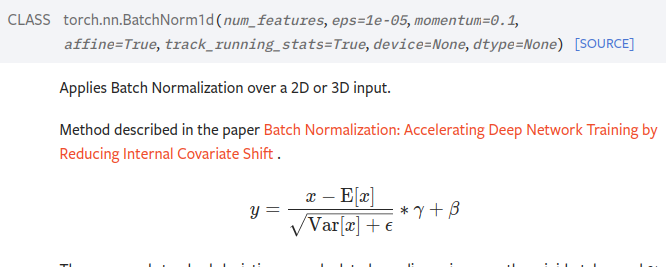

#Normalization ,BatchNorm:
     * Typicaly Normalizing process consists of scaling The Neumaric data Down to 0--->1
     * in standard Norm Process, Subtract Mean of Data set From each Data poing
          + z = datapoing - Mean / STD
     * This force to standard Data to take an Mean of Zero0 and STD of one1
     * in practic this stardrd Proces refer As Normalization as well

### When Apply batchnorm to layer, Normalize Output from Activation Funcs
      z = dataPoing - Mean / Std

     * after that batch Norm will mul this norm output by artbity para[Gamma], and then aadd antoher arbitry para[Beta] to this result
     z = z*gamma + beta

     *  Those cal would give new Mean and STD
    
### * Normaliz happen to data before passed into Input Layer

### * Now with this BatchNorm we can normalize the Output from the activation function for Individual layers


In [ ]:


class Linear:
    def __init__(self, fanIn, fanOut, bias=True):
        self.weight = torch.randn((fanIn, fanOut), generator=g) / fanIn**0.5
        self.biase = torch.zeros(fanOut) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.biase is not None:
            self.out += self.biase
        return self.out

    def para(self):
        return [self.weight] + ([] if self.biase is  None else [self.biase])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, moment=0.1):
        self.eps = eps #epsilon
        self.moment = moment
        self.training = True

        #para Trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        #buffers (trained with a runnign 'momentum update')
        self.runningMean = torch.zeros(dim) #batch mean
        self.runningVar = torch.ones(dim)  # batch variance

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) #batch norm
            xvar = x.var(0, keepdim=True) #batch varienc
        else:
            xmean = self.runningMean
            xvar = self.runningVar
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        #update buffers
        if self.training:
            with torch.no_grad():
                self.runningMean = (1 - self.moment) * self.runningMean + self.moment * xmean
                self.runningVar = (1 - self.moment) * self.runningVar + self.moment * xvar

        return self.out

    def para(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def para(self):
        return []


In [ ]:

nEmb = 10 # dim  of char embedding vectors
nHidden = 100
g = torch.Generator().manual_seed(2147483647)
blocksiz = 3

In [ ]:
#C = torch.randn((vocabSiz, nEmb), generator=g)
#layers = [
#  Linear(nEmb * blocksiz, nHidden),    Tanh(),
#  Linear(           nHidden, nHidden), Tanh(),
#  Linear(           nHidden, nHidden), Tanh(),
#  Linear(           nHidden, nHidden), Tanh(),
#  Linear(           nHidden, nHidden), Tanh(),
#  Linear(           nHidden, vocabSiz),
#]

C = torch.randn((vocabSiz, nEmb), generator=g)
layers = [
  Linear(nEmb * blocksiz, nHidden), BatchNorm1d(nHidden), Tanh(),
  Linear(           nHidden, nHidden), BatchNorm1d(nHidden), Tanh(),
  Linear(           nHidden, nHidden), BatchNorm1d(nHidden), Tanh(),
  Linear(           nHidden, nHidden), BatchNorm1d(nHidden) ,Tanh(),
  Linear(           nHidden, nHidden), BatchNorm1d(nHidden), Tanh(),
  Linear(           nHidden, vocabSiz), BatchNorm1d(vocabSiz)
]

 + becuas the last leyer is batchnorm we would not be** changing the weights**
 to make softmak less Confidence
     * layers[-1].weight *= 0.1
     * Use--> Gamma layers[-1].gamma *= 0.1
 + Why Use gamma insted weights::
     * becuas gamma is the variable in Batchnorm That mul interact with the output
     of that normalization

In [ ]:

with torch.no_grad():
    #last Layer:: make Less Confident
    #layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    #all other layers apply Gain
    for layr in layers[:-1]:
        if isinstance(layr, Linear):
            layr.weight  *= 5/3


In [ ]:

para = [C] + [p for layr in layers for p in layr.para()]
print(sum(p.nelement() for p in para))
for p in para:
    p.requires_grad = True


47551


In [ ]:
maxSteps = 200000
batchSiz = 32
loss_i = []
ud = [] #update to data Ratio

for i in range(maxSteps):
    #minibatch Construct
    ix = torch.randint(0, xTrain.shape[0], (batchSiz,), generator=g)
    Xb, Yb = xTrain[ix], yTrain[ix] #batch x/y

    #forwardPass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) #construct vec
    for lyr in layers:
        x = lyr(x)
    loss = F.cross_entropy(x, Yb) #loss Func

    #backward Pass
    for lyr in layers:
        lyr.out.retain_grad() #AFTER DEBGU; would takeout retain graph

    for p in para:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in para:
        p.data += -lr * p.grad

    # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    for p in para:
        p.data += -lr * p.grad

    if i % 10000 == 0: #print evry once in a while
        print(f'{i:7d}/{maxSteps:7d}: {loss.item():.4f}')
    loss_i.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in para])
    if i > 2000:
        break



      0/ 200000: 3.2870


#Changing (W2) and (b2)
1. Why change (W2) and (b2) for a good initial loss?

    * When you're training a neural network, the initial values of the weights and biases can significantly impact how fast the network learns and even whether it can learn effectively at all.  If the initial values are too large or too small, it can make the learning process unstable or slow. Starting with a good initial loss means the network is in a reasonably good place to start learning.
    
    * It won't waste time adjusting to a more reasonable starting point, and it's less likely to get stuck in a poor solution.

### W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 // mul by 0.01
### b2 = torch.randn(vocab_size,                      generator=g) * 0 //mul by 0

##w2:
   * init with small random values (multiplied by 0.01). This is a common practice to ensure that the outputs (logits) of the network are small.

   *  Small logits fed into a softmax function will produce a **distribution** that's **close to uniform**. This means the network starts with a** guess that's close to "I'm equally unsure about each class,"** which is a reasonable starting point.
   
##b2:
   * initi to zero, it's Cos the bias term in NN is responsible for **shifting** **the output of a neuron.**

   * Init biases to zero means we're not giving any class an initial advantage. Over time, as the network learns, it will adjust these biases based on the data.
   


#STATS

  1. STD[Standard Deviation]:
        + this tells us **How Wider the Curve** Should be
        and the wider the curve The lower and Narrow the Curve The Higher[some qty]
  
  2. Mean:
        + Sum of measuerment / the Num of the Measurment
        
        * also ther's:
            + Population Mean
            + Estimated Population Mean
   
   3. Variance:
        The popultion Variance is the Avg of SquareRoot defferent Between Data and Population Mean
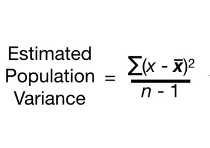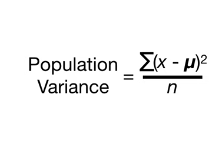
        

layer 2 (      Tanh): mean -0.00, std 0.62, saturated: 3.84%
layer 5 (      Tanh): mean -0.01, std 0.65, saturated: 3.28%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 3.00%
layer 11 (      Tanh): mean -0.00, std 0.66, saturated: 2.28%
layer 14 (      Tanh): mean -0.01, std 0.67, saturated: 1.97%


Text(0.5, 1.0, 'activation distribution')

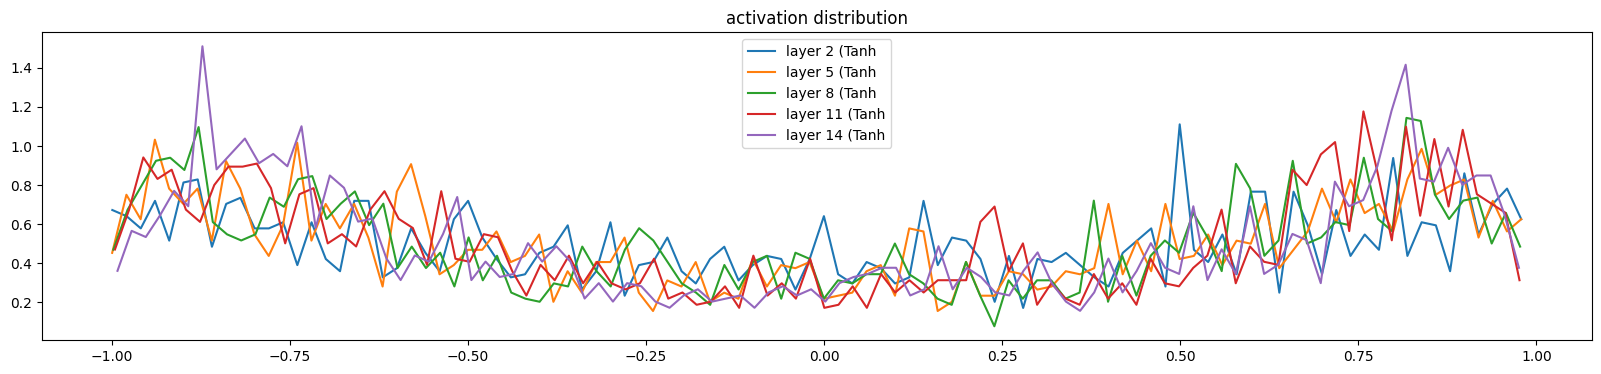

In [ ]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (
        i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100
    ))

    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

#Gradient Dist

layer 2 (      Tanh): mean -0.000000, std 2.427322e-03
layer 5 (      Tanh): mean +0.000000, std 2.117282e-03
layer 8 (      Tanh): mean +0.000000, std 2.036243e-03
layer 11 (      Tanh): mean -0.000000, std 2.039622e-03
layer 14 (      Tanh): mean +0.000000, std 2.193295e-03


Text(0.5, 1.0, 'gradient distribution')

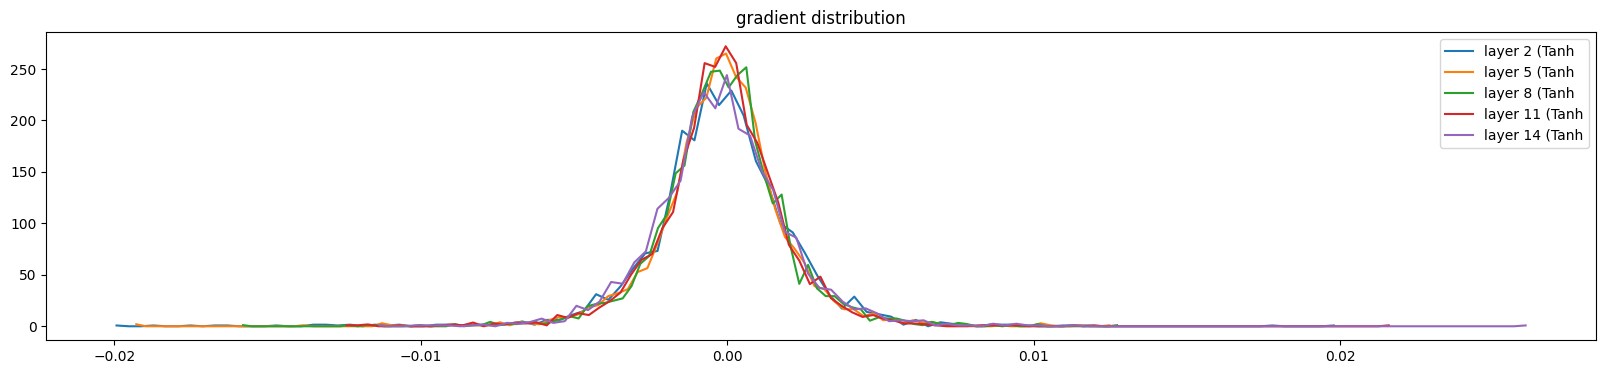

In [ ]:
# visualize histograms 1.0
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 9.523842e-03 | grad:data ratio 9.490221e-03
weight  (30, 100) | mean -0.000098 | std 5.535693e-03 | grad:data ratio 1.745604e-02
weight (100, 100) | mean -0.000023 | std 3.746468e-03 | grad:data ratio 2.171732e-02
weight (100, 100) | mean +0.000018 | std 3.499062e-03 | grad:data ratio 2.028455e-02
weight (100, 100) | mean -0.000019 | std 3.412654e-03 | grad:data ratio 1.992944e-02
weight (100, 100) | mean +0.000005 | std 3.474317e-03 | grad:data ratio 2.032081e-02
weight  (100, 27) | mean -0.000028 | std 7.344893e-03 | grad:data ratio 4.104285e-02


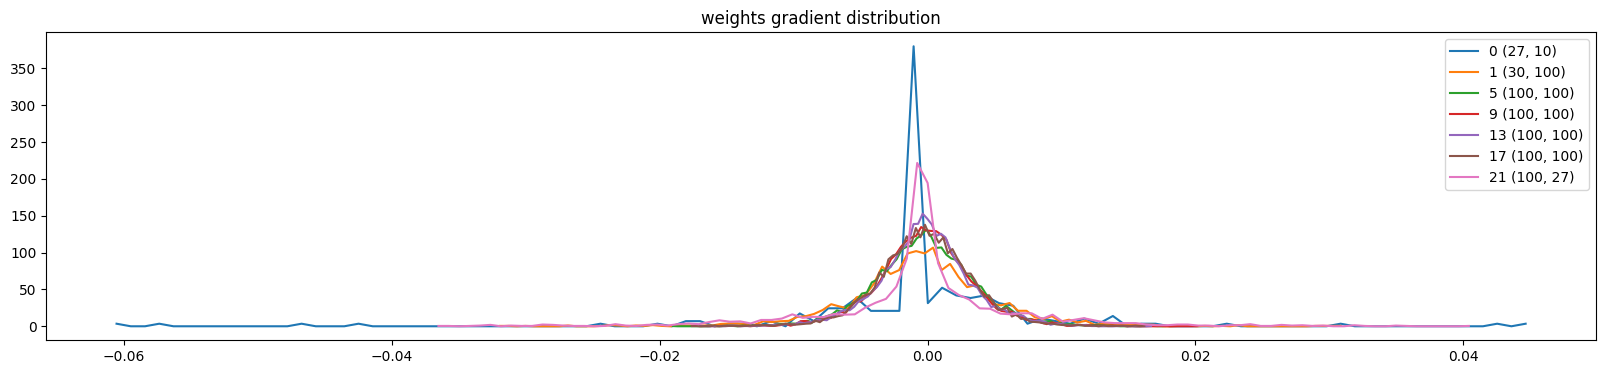

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(para):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

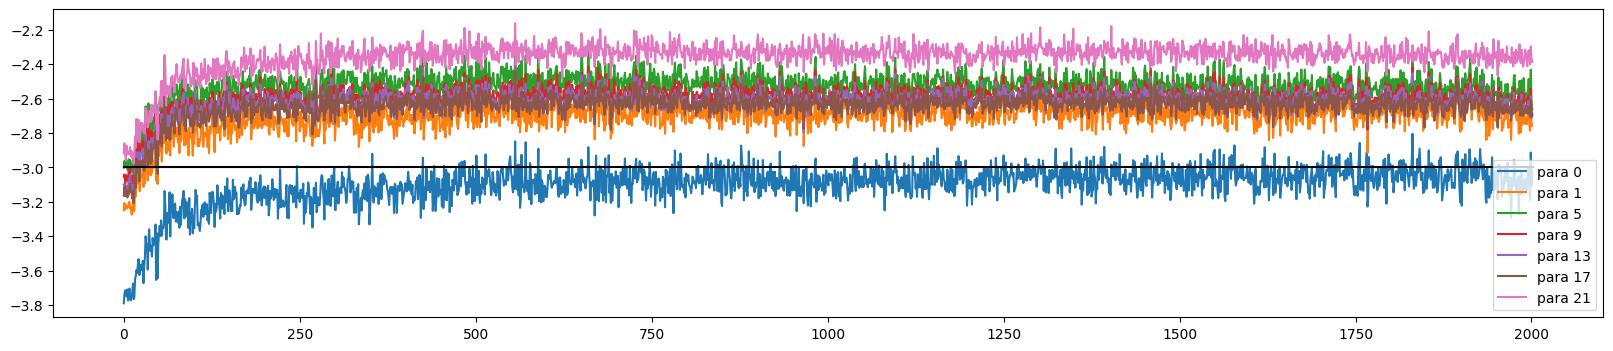

In [ ]:

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(para):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('para %d' % i)
plt.plot([0, len(ud)],  [-3, -3], 'k')
plt.legend(legends);

In [ ]:
@torch.no_grad()
def splitLoss(split):
    x, y = {
        'train': (xTrain, yTrain),
        'dev': (xDev, yDev),
        'test': (xTst, yTst)
    }[split]

    emb = C[x]
    x =  emb.view(emb.shape[0], -1)
    for lyr in layers:
        x = lyr(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

#put layers into eval mode
for lyr in layers:
    lyr.training = False


splitLoss('train')
splitLoss('dev')

train 3.2662177085876465
dev 3.2655985355377197
